# Imports

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests
import math
from PIL import Image
from io import BytesIO
from collections import Counter
from sklearn.model_selection import train_test_split


import wandb
from wandb.keras import WandbCallback

# Tensorflow imports

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Check if GPU/CPU is connected

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12824437532046551844
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11783376283594365852
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4973462816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4350072850570873877
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6210251960600856250
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
path = 'dataset/'
classes = os.listdir(path) # List of all classes
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))    
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)
imbalanced = [i[0] for i in imbalanced]

In [5]:
def getImages(size_x, size_y, grayScale=False, datagenEnabled=True):
    channels = 3
    if grayScale:
        channels = 1
    X = [] 
    Y = [] 
    for c in classes:
        if c in imbalanced:
            dir_path = os.path.join(path, c)
            label = imbalanced.index(c)        
            for i in os.listdir(dir_path):
                if grayScale:
                    img = cv.imread(os.path.join(dir_path, i))
                    image = cv.cvtColor(img, cv.COLOR_BGRA2GRAY)
                else:
                    image = cv.imread(os.path.join(dir_path, i))            
                try:
                    resized = cv.resize(image, (size_x, size_y))
                    X.append(resized)
                    Y.append(label)            
                except:
                    print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                    continue
    X = np.array(X).reshape(-1, size_x, size_y, channels)
    X = X / 255.0
    y = to_categorical(Y, num_classes = len(imbalanced))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)
    if datagenEnabled:
        datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2,
                                    )
    else:
        datagen = ImageDataGenerator()
    datagen.fit(X_train)
    img = X_test[293]
    img = img.reshape([-1, size_x, size_y, channels])

    fig = plt.figure(figsize = (18, 8))
    for i, flow in enumerate(datagen.flow(img, batch_size = 1)):
        fig.add_subplot(2, 5, i+1)
        plt.imshow(np.squeeze(flow[:, :, ::-1]))
        plt.axis('off')
        i += 1    
        if i >= 10:
            break
    
    return X_train, X_test, y_train, y_test, datagen

In [6]:
sweep_config = {
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['Adam', 'SGD', 'RMSprop','Adagrad']
        },

    'loss': {
        'values': ['categorical_crossentropy','poisson']
        },


    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.05
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(16),
        'max': math.log(64),
      },

    'epochs': {
        'distribution': 'int_uniform',
        'min':30,
        'max': 50,
        },
    'dropout_layers':{
       'values': [0.05,0.1,0.15,0.2, 0.25]
    },
     'pooling':{
         'values' : [2,3]
     },
     'gauss':{
        'distribution': 'uniform',
        'min': 0,
        'max': 0.3
        }
     }
  }   


In [7]:
def getOpt(name,rl):
    if name ==  'Adam':
        return keras.optimizers.Adam(learning_rate=rl)
    elif name =='SGD':
        return keras.optimizers.SGD(learning_rate=rl)
    elif name =='RMSprop':
        return keras.optimizers.RMSprop(learning_rate=rl)
    else:
        return keras.optimizers.Adagrad(learning_rate=rl)

# RGB 128x128 - notransformation, bigger

dataset/Caterpie\dcd36168d2bd470aaca333fb3bdf6bfa.svg [ERROR] can't read the file
dataset/Cloyster\ff270ebfab0f46b3b05c3fecd6a15ef9.svg [ERROR] can't read the file
dataset/Dewgong\e3ecbb47e192470aa8686734b7813b43.svg [ERROR] can't read the file
dataset/Electabuzz\28a02c7a1389471693ff89712f1064f3.svg [ERROR] can't read the file
dataset/Exeggutor\2b8bc491c5ca4e788999f8ea53617638.svg [ERROR] can't read the file
dataset/Exeggutor\f29b4f9fccff4055b167ece6556143cd.svg [ERROR] can't read the file
dataset/Fearow\2c8d5221e92444f2b9477350e405bc54.svg [ERROR] can't read the file
dataset/Fearow\8f2d7986ab76482fb76cac6a91b66de4.svg [ERROR] can't read the file
dataset/Golduck\bc08a691e7cb41b0bec2adf931dc9634.svg [ERROR] can't read the file
dataset/Graveler\3fe3c6a0bbd14de89092d2c675f743c1.svg [ERROR] can't read the file
dataset/Growlithe\f7a87c057dc94a32a0d5aedd1abed088.svg [ERROR] can't read the file
dataset/Gyarados\6444e4ec716b44a4959bf97c1e75a935.svg [ERROR] can't read the file
dataset/Hypno\ea3

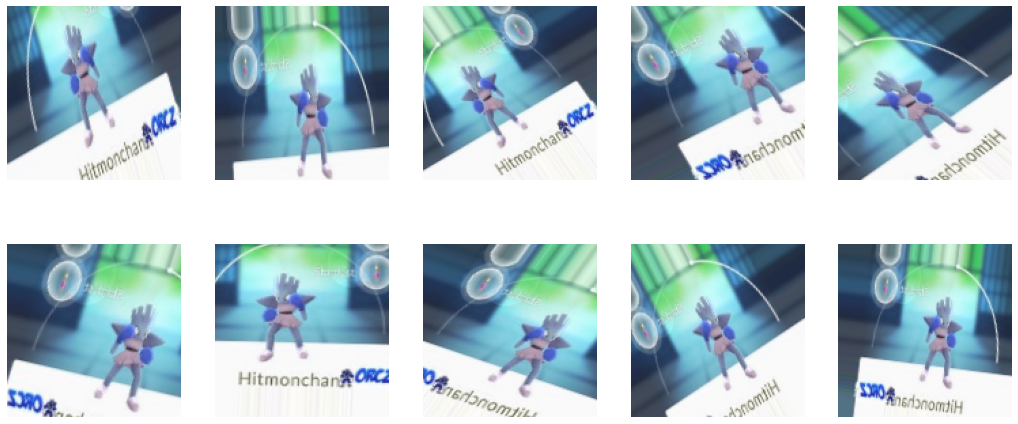

In [8]:
X_train, X_test, y_train, y_test, datagen = getImages(128,128,grayScale=False,datagenEnabled=True)

In [9]:
def train5():
        with wandb.init(config=sweep_config):
            config = wandb.config
            if wandb.run:
                model = Sequential()
                model.add(GaussianNoise(config.gauss,input_shape = (128, 128, 3)))
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu',  kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                checkpoint = ModelCheckpoint('../working/model_9696_notransformation_bigger.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=10)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   


In [10]:
%%time
wandb.init(project="NN-zadanie2")
sweep_config['name'] = "NN-zadanie2-sweep-9696guss-bigger"
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train5, count=10)

wandb: Currently logged in as: ramang (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: xgw48u9m
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/xgw48u9m


wandb: Agent Starting Run: fvvsnh6d with config:
wandb: 	batch_size: 48
wandb: 	dropout_layers: 0.05
wandb: 	epochs: 34
wandb: 	gauss: 0.0050404985344159265
wandb: 	learning_rate: 0.0023185337629236303
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/34
177/177 [==============================] - 24s 137ms/step - loss: 0.0485 - accuracy: 0.0077 - val_loss: 0.0412 - val_accuracy: 0.0089
Epoch 2/34
177/177 [==============================] - 24s 134ms/step - loss: 0.0483 - accuracy: 0.0068 - val_loss: 0.0416 - val_accuracy: 0.0080
Epoch 3/34
177/177 [==============================] - 24s 137ms/step - loss: 0.0483 - accuracy: 0.0052 - val_loss: 0.0419 - val_accuracy: 0.0084
Epoch 4/34
177/177 [==============================] - 24s 135ms/step - loss: 0.0482 - accuracy: 0.0071 - val_loss: 0.0425 - val_accuracy: 0.0070
Epoch 5/34
177/177 [==============================] - 24s 136ms/step - loss: 0.0483 - accuracy: 0.0067 - val_loss: 0.0429 - val_accuracy: 0.0052
Epoch 6/34
177/177 [==============================] - 24s 136ms/step - loss: 0.0482 - accuracy: 0.0072 - val_loss: 0.0430 - val_accuracy: 0.0042
Epoch 7/34
177/177 [==============================] - 24s 136ms/step - loss: 0.0483 - accuracy: 0.0073 - val_loss: 0.0430 - val_ac

epoch,33
loss,0.04719
accuracy,0.00943
val_loss,0.04186
val_accuracy,0.01125
_runtime,820
_timestamp,1618305680
_step,33
best_val_loss,0.04119
best_epoch,0


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▇▆▇▆▆▆▆▅▅▄▆▃▅▄▃▄▃▄▃▂▃▂▂▂▂▂▁▂▂▁
accuracy,▄▃▁▄▃▄▄▃▅▅▄▆▃▃▅▄▄▅▄▆▆▄▃▆▄▆▅█▄▅█▆▅▇
val_loss,▁▃▄▆██████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄
val_accuracy,▅▄▄▃▂▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▃▄▄▄▄▆▆▇▇██▇
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: y0e3wxka with config:
wandb: 	batch_size: 49
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 34
wandb: 	gauss: 0.25131061866479165
wandb: 	learning_rate: 0.0026110708276286866
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/34
174/174 [==============================] - 25s 142ms/step - loss: 5.1727 - accuracy: 0.0507 - val_loss: 4.5088 - val_accuracy: 0.0755
Epoch 2/34
174/174 [==============================] - 24s 140ms/step - loss: 4.4020 - accuracy: 0.0970 - val_loss: 4.2798 - val_accuracy: 0.1031
Epoch 3/34
174/174 [==============================] - 24s 140ms/step - loss: 4.0754 - accuracy: 0.1205 - val_loss: 4.2816 - val_accuracy: 0.1120
Epoch 4/34
174/174 [==============================] - 24s 141ms/step - loss: 3.8297 - accuracy: 0.1464 - val_loss: 3.7250 - val_accuracy: 0.1627
Epoch 5/34
174/174 [==============================] - 24s 138ms/step - loss: 3.6873 - accuracy: 0.1648 - val_loss: 3.7773 - val_accuracy: 0.1678
Epoch 6/34
174/174 [==============================] - 24s 139ms/step - loss: 3.5442 - accuracy: 0.1789 - val_loss: 3.8645 - val_accuracy: 0.1364
Epoch 7/34
174/174 [==============================] - 24s 138ms/step - loss: 3.4650 - accuracy: 0.1918 - val_loss: 3.7967 - val_ac

epoch,33
loss,2.47837
accuracy,0.37263
val_loss,3.44757
val_accuracy,0.24051
_runtime,831
_timestamp,1618306515
_step,33
best_val_loss,3.13161
best_epoch,32


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁
accuracy,▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███▇▇▇██
val_loss,█▇▇▄▄▅▄▅▃▃▄▂▄▂▂▆▄▄▄▄▄▅▃▂▂▂▂▃▂▅▄▃▁▃
val_accuracy,▁▂▂▄▄▃▄▄▆▆▄▆▅▆▆▃▄▄▅▄▄▄▆▇▇▇▇▇▆▄▅▆█▇
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mf7eyxls with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 47
wandb: 	gauss: 0.25251629761820915
wandb: 	learning_rate: 0.004847709078977941
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/47
406/406 [==============================] - 25s 61ms/step - loss: 5.6735 - accuracy: 0.0217 - val_loss: 6.0279 - val_accuracy: 0.0206
Epoch 2/47
406/406 [==============================] - 24s 60ms/step - loss: 5.2476 - accuracy: 0.0425 - val_loss: 54.1979 - val_accuracy: 0.0103
Epoch 3/47
406/406 [==============================] - 24s 59ms/step - loss: 5.0627 - accuracy: 0.0526 - val_loss: 121.1089 - val_accuracy: 0.0075
Epoch 4/47
406/406 [==============================] - 24s 59ms/step - loss: 4.9089 - accuracy: 0.0647 - val_loss: 100.1300 - val_accuracy: 0.0084
Epoch 5/47
406/406 [==============================] - 24s 60ms/step - loss: 4.7865 - accuracy: 0.0734 - val_loss: 99.2811 - val_accuracy: 0.0084
Epoch 6/47
406/406 [==============================] - 24s 59ms/step - loss: 4.6807 - accuracy: 0.0751 - val_loss: 94.2453 - val_accuracy: 0.0084
Epoch 7/47
406/406 [==============================] - 24s 59ms/step - loss: 4.6387 - accuracy: 0.0802 - val_loss: 83.6184 - val_a

epoch,46
loss,3.80803
accuracy,0.15133
val_loss,41.86948
val_accuracy,0.02344
_runtime,1150
_timestamp,1618307680
_step,46
best_val_loss,6.02794
best_epoch,0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇█▇████
val_loss,▁▄█▇▇▆▆▅▅▅▅▅▄▄▄▄▅▄▄▅▄▄▄▄▃▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃
val_accuracy,▆▂▁▁▁▁▂▃▃▃▄▃▅▅▅▅▆▅▅▅▅▅▆▆▆▆▆▆▅▆▆▆▆▇▇▇█▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: i4sx8xns with config:
wandb: 	batch_size: 63
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 32
wandb: 	gauss: 0.1136707050217244
wandb: 	learning_rate: 0.002102904258880173
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/32
135/135 [==============================] - 23s 169ms/step - loss: 5.1269 - accuracy: 0.0554 - val_loss: 4.8506 - val_accuracy: 0.0497
Epoch 2/32
135/135 [==============================] - 23s 169ms/step - loss: 4.3937 - accuracy: 0.0998 - val_loss: 4.9496 - val_accuracy: 0.0647
Epoch 3/32
135/135 [==============================] - 23s 170ms/step - loss: 4.0608 - accuracy: 0.1320 - val_loss: 4.3318 - val_accuracy: 0.0999
Epoch 4/32
135/135 [==============================] - 23s 170ms/step - loss: 3.8396 - accuracy: 0.1516 - val_loss: 4.1877 - val_accuracy: 0.1331
Epoch 5/32
135/135 [==============================] - 23s 171ms/step - loss: 3.6898 - accuracy: 0.1685 - val_loss: 3.7830 - val_accuracy: 0.1697
Epoch 6/32
135/135 [==============================] - 23s 171ms/step - loss: 3.5861 - accuracy: 0.1876 - val_loss: 3.5504 - val_accuracy: 0.1903
Epoch 7/32
135/135 [==============================] - 23s 172ms/step - loss: 3.4903 - accuracy: 0.1970 - val_loss: 3.6913 - val_ac

epoch,31
loss,2.5356
accuracy,0.38529
val_loss,3.29686
val_accuracy,0.28317
_runtime,769
_timestamp,1618308453
_step,31
best_val_loss,3.0807
best_epoch,28


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,██▆▅▄▃▃▄▃▃▃▂▂▂▄▂▂▂▂▂▁▂▁▂▂▂▂▂▁▂▁▂
val_accuracy,▁▁▂▃▄▅▄▄▅▆▅▆▆▆▅▆▆▆▆▇▇▆█▆▇▇▇▇█▇█▇
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: dcol0k78 with config:
wandb: 	batch_size: 52
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 38
wandb: 	gauss: 0.2519606361207978
wandb: 	learning_rate: 0.008888188031428818
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/38
164/164 [==============================] - 25s 150ms/step - loss: 5.9014 - accuracy: 0.0157 - val_loss: 5.7394 - val_accuracy: 0.0075
Epoch 2/38
164/164 [==============================] - 24s 147ms/step - loss: 5.4359 - accuracy: 0.0353 - val_loss: 5.3223 - val_accuracy: 0.0295
Epoch 3/38
164/164 [==============================] - 24s 147ms/step - loss: 5.1712 - accuracy: 0.0559 - val_loss: 5.9790 - val_accuracy: 0.0305
Epoch 4/38
164/164 [==============================] - 24s 146ms/step - loss: 5.0011 - accuracy: 0.0686 - val_loss: 9.6254 - val_accuracy: 0.0342
Epoch 5/38
164/164 [==============================] - 24s 147ms/step - loss: 4.8554 - accuracy: 0.0789 - val_loss: 25.3798 - val_accuracy: 0.0150
Epoch 6/38
164/164 [==============================] - 24s 148ms/step - loss: 4.7081 - accuracy: 0.0846 - val_loss: 30.4488 - val_accuracy: 0.0113
Epoch 7/38
164/164 [==============================] - 25s 150ms/step - loss: 4.6153 - accuracy: 0.0857 - val_loss: 35.7724 - val

epoch,37
loss,3.62165
accuracy,0.18455
val_loss,6.19489
val_accuracy,0.05063
_runtime,953
_timestamp,1618309411
_step,37
best_val_loss,5.32225
best_epoch,1


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████
val_loss,▁▁▁▂▆▇██▆▆▆▆▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▄▅▂▂▂▂▂▂▂▂▂▃▃▃▂▃▃▄▄▆▅▃▅▄▅▅▆▆▆▆▇██▇█▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4lt1qs3m with config:
wandb: 	batch_size: 38
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 43
wandb: 	gauss: 0.250645792245557
wandb: 	learning_rate: 0.049599061147259385
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/43
224/224 [==============================] - 26s 117ms/step - loss: 0.0474 - accuracy: 0.0106 - val_loss: 0.0423 - val_accuracy: 0.0117
Epoch 2/43
224/224 [==============================] - 26s 115ms/step - loss: 0.0464 - accuracy: 0.0165 - val_loss: 0.0423 - val_accuracy: 0.0220
Epoch 3/43
224/224 [==============================] - 26s 114ms/step - loss: 0.0453 - accuracy: 0.0247 - val_loss: 0.0425 - val_accuracy: 0.0342
Epoch 4/43
224/224 [==============================] - 27s 118ms/step - loss: 0.0446 - accuracy: 0.0340 - val_loss: 0.0422 - val_accuracy: 0.0474
Epoch 5/43
224/224 [==============================] - 27s 118ms/step - loss: 0.0439 - accuracy: 0.0394 - val_loss: 0.0440 - val_accuracy: 0.0445
Epoch 6/43
224/224 [==============================] - 26s 116ms/step - loss: 0.0431 - accuracy: 0.0472 - val_loss: 0.0445 - val_accuracy: 0.0455
Epoch 7/43
224/224 [==============================] - 26s 115ms/step - loss: 0.0427 - accuracy: 0.0504 - val_loss: 0.0450 - val_ac

epoch,42
loss,0.03531
accuracy,0.12244
val_loss,0.04865
val_accuracy,0.05298
_runtime,1204
_timestamp,1618310622
_step,42
best_val_loss,0.04087
best_epoch,17


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▁▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇██
val_loss,▂▂▂▂▃▄▄▂▄▄▃▂▃▂▂▁▁▁▂▃▄▄▇█▇▇▆▇▆▆▆▆▆▆▅█▇▇▇▆
val_accuracy,▁▂▄▆▆▆▇▇▆▆▆▇▇▇█▇██▇▇▇▇▆▆▇▆▇▇▇▇▆▇▆▆▇▆▆▆▆▇
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 8y9ltzei with config:
wandb: 	batch_size: 48
wandb: 	dropout_layers: 0.2
wandb: 	epochs: 40
wandb: 	gauss: 0.14593803935644914
wandb: 	learning_rate: 0.026899363995064998
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/40
177/177 [==============================] - 26s 147ms/step - loss: 0.0415 - accuracy: 0.0580 - val_loss: 0.0390 - val_accuracy: 0.0736
Epoch 2/40
177/177 [==============================] - 26s 146ms/step - loss: 0.0365 - accuracy: 0.0825 - val_loss: 0.0351 - val_accuracy: 0.0999
Epoch 3/40
177/177 [==============================] - 25s 140ms/step - loss: 0.0355 - accuracy: 0.0949 - val_loss: 0.0390 - val_accuracy: 0.0806
Epoch 4/40
177/177 [==============================] - 26s 146ms/step - loss: 0.0350 - accuracy: 0.1010 - val_loss: 0.0364 - val_accuracy: 0.0919
Epoch 5/40
177/177 [==============================] - 25s 142ms/step - loss: 0.0344 - accuracy: 0.1119 - val_loss: 0.0362 - val_accuracy: 0.0825
Epoch 6/40
177/177 [==============================] - 24s 137ms/step - loss: 0.0341 - accuracy: 0.1153 - val_loss: 0.0342 - val_accuracy: 0.1341
Epoch 7/40
177/177 [==============================] - 24s 138ms/step - loss: 0.0339 - accuracy: 0.1152 - val_loss: 0.0333 - val_ac

epoch,39
loss,0.02914
accuracy,0.22973
val_loss,0.02957
val_accuracy,0.22691
_runtime,991
_timestamp,1618311627
_step,39
best_val_loss,0.02731
best_epoch,29


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁
accuracy,▁▂▂▃▃▃▃▄▄▄▄▅▅▄▅▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
val_loss,▆▄▆▅▅▄▄▄▃▃▂▃▄▃▃▃▃▄▂▃▃█▂▂▂▂▂▂▂▁▂▁▂▁▂▃▁▁▂▂
val_accuracy,▁▂▁▂▁▃▄▃▄▄▅▄▄▄▄▄▃▃▆▄▄▂▅▆▅▆▅▅▆█▇▇▇█▆▅▇█▆▆
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fk4a4wlh with config:
wandb: 	batch_size: 40
wandb: 	dropout_layers: 0.05
wandb: 	epochs: 43
wandb: 	gauss: 0.19834054062334866
wandb: 	learning_rate: 0.02156406540664281
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/43
213/213 [==============================] - 25s 116ms/step - loss: 5.2049 - accuracy: 0.0511 - val_loss: 4.6232 - val_accuracy: 0.0455
Epoch 2/43
213/213 [==============================] - 24s 114ms/step - loss: 4.5112 - accuracy: 0.0942 - val_loss: 4.3976 - val_accuracy: 0.0933
Epoch 3/43
213/213 [==============================] - 25s 117ms/step - loss: 4.2124 - accuracy: 0.1145 - val_loss: 4.1391 - val_accuracy: 0.1074
Epoch 4/43
213/213 [==============================] - 25s 115ms/step - loss: 4.0099 - accuracy: 0.1297 - val_loss: 4.2319 - val_accuracy: 0.1111
Epoch 5/43
213/213 [==============================] - 24s 114ms/step - loss: 3.8595 - accuracy: 0.1505 - val_loss: 4.2492 - val_accuracy: 0.1045
Epoch 6/43
213/213 [==============================] - 25s 117ms/step - loss: 3.7446 - accuracy: 0.1580 - val_loss: 3.9641 - val_accuracy: 0.1388
Epoch 7/43
213/213 [==============================] - 24s 114ms/step - loss: 3.6597 - accuracy: 0.1757 - val_loss: 4.1325 - val_ac

epoch,42
loss,2.42218
accuracy,0.38483
val_loss,3.83411
val_accuracy,0.20113
_runtime,1083
_timestamp,1618312716
_step,42
best_val_loss,3.64645
best_epoch,37


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
val_loss,█▆▅▅▅▃▄▄▄▃▅▃▂▂▂▃▃▃▄▃▃▅▄▄▄▄▄▂▅▃▆▆▆▅▂▁▂▂▄▂
val_accuracy,▁▃▄▄▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▆▆▆▆▆▇▇█▇█▇▇
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: lbfsbuz5 with config:
wandb: 	batch_size: 23
wandb: 	dropout_layers: 0.2
wandb: 	epochs: 45
wandb: 	gauss: 0.2855579825785745
wandb: 	learning_rate: 0.030969840088420453
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/45
370/370 [==============================] - 27s 73ms/step - loss: 0.0483 - accuracy: 0.0059 - val_loss: 0.0434 - val_accuracy: 0.0052
Epoch 2/45
370/370 [==============================] - 25s 69ms/step - loss: 0.0478 - accuracy: 0.0076 - val_loss: 0.0477 - val_accuracy: 0.0089
Epoch 3/45
370/370 [==============================] - 25s 68ms/step - loss: 0.0474 - accuracy: 0.0087 - val_loss: 0.0538 - val_accuracy: 0.0084
Epoch 4/45
370/370 [==============================] - 25s 66ms/step - loss: 0.0473 - accuracy: 0.0073 - val_loss: 0.0807 - val_accuracy: 0.0052
Epoch 5/45
370/370 [==============================] - 24s 66ms/step - loss: 0.0468 - accuracy: 0.0113 - val_loss: 0.0794 - val_accuracy: 0.0089
Epoch 6/45
370/370 [==============================] - 25s 67ms/step - loss: 0.0463 - accuracy: 0.0136 - val_loss: 0.1090 - val_accuracy: 0.0188
Epoch 7/45
370/370 [==============================] - 24s 66ms/step - loss: 0.0459 - accuracy: 0.0183 - val_loss: 0.1098 - val_accuracy:

epoch,44
loss,0.03886
accuracy,0.06546
val_loss,0.10454
val_accuracy,0.01219
_runtime,1167
_timestamp,1618313894
_step,44
best_val_loss,0.04335
best_epoch,0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▇▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
accuracy,▁▁▁▁▂▂▂▃▄▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▆▇▇▇█▇█▇▇▇█
val_loss,▁▁▂▅▅███▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇▇█▇▇▇▇▇█▇
val_accuracy,▁▂▂▁▂▅▄▅▇█▇▄▅▄▃▄▃▃▃▂▂▂▂▂▂▂▃▃▄▄▄▄▃▃▃▃▄▃▃▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: woojmq7e with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 34
wandb: 	gauss: 0.005928463378898352
wandb: 	learning_rate: 0.014384158340552384
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/34
406/406 [==============================] - 38s 94ms/step - loss: 5.6184 - accuracy: 0.0258 - val_loss: 5.0936 - val_accuracy: 0.0328
Epoch 2/34
406/406 [==============================] - 26s 64ms/step - loss: 5.0297 - accuracy: 0.0519 - val_loss: 4.5312 - val_accuracy: 0.0910
Epoch 3/34
406/406 [==============================] - 26s 63ms/step - loss: 4.7724 - accuracy: 0.0673 - val_loss: 4.3759 - val_accuracy: 0.0938
Epoch 4/34
406/406 [==============================] - 26s 63ms/step - loss: 4.5870 - accuracy: 0.0841 - val_loss: 4.2528 - val_accuracy: 0.1069
Epoch 5/34
406/406 [==============================] - 25s 63ms/step - loss: 4.4141 - accuracy: 0.0927 - val_loss: 4.1446 - val_accuracy: 0.1195
Epoch 6/34
406/406 [==============================] - 25s 61ms/step - loss: 4.3218 - accuracy: 0.1010 - val_loss: 4.2030 - val_accuracy: 0.1252
Epoch 7/34
406/406 [==============================] - 25s 61ms/step - loss: 4.2181 - accuracy: 0.1090 - val_loss: 4.0934 - val_accuracy:

epoch,33
loss,3.45802
accuracy,0.19951
val_loss,3.43943
val_accuracy,0.20956
_runtime,874
_timestamp,1618314776
_step,33
best_val_loss,3.43559
best_epoch,29


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▄▄▅▅▅▅▆▅▅▆▆▆▆▆▇▇▇▇▇▇▇███▇████
val_loss,█▆▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇███████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


Wall time: 2h 45min 27s
